In [3]:
import pandas as pd
import networkx as nx
import re
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [8]:
nodes = pd.read_csv(r'C:\Users\ADMIN\Downloads\graph_rag-main (2)\graph_rag-main\data\final\nodes_final.csv')
edges = pd.read_csv(r'C:\Users\ADMIN\Downloads\graph_rag-main (2)\graph_rag-main\data\final\edges.csv')
print('Nodes:', nodes.shape)
print('Edges:', edges.shape)

Nodes: (2299, 3)
Edges: (10257, 3)


In [10]:
clean_to_link = {}

def clean_title(name):
    name = name.replace("_", " ")
    name = re.sub(r'\b\w', lambda m: m.group().upper(), name)
    name = re.sub(r'\s+', ' ', name).strip(' ,.()')
    return name

for _, row in nodes.iterrows():
    link = row['link']
    if isinstance(link, str) and link.startswith("/wiki/"):
        clean_name = clean_title(link[6:])
        clean_to_link[clean_name] = link

print(f"→ Mapping name → link: {len(clean_to_link):,} nút")

→ Mapping name → link: 2,278 nút


In [11]:
person_clean_names = []

for _, row in nodes[nodes['type'] == 'PERSON'].iterrows():
    link = row['link']
    if isinstance(link, str) and link.startswith("/wiki/"):
        clean_name = clean_title(link[6:])
        person_clean_names.append(clean_name)

print(f"→ Số nhà khoa học PERSON: {len(person_clean_names):,}")

→ Số nhà khoa học PERSON: 991


In [12]:
person_edges = edges[
    edges['src'].isin(person_clean_names) |
    edges['des'].isin(person_clean_names)
].copy()

print(f"→ Số cạnh liên quan tới người: {len(person_edges):,}")

→ Số cạnh liên quan tới người: 9,306


In [13]:
person_edges = edges[
    edges['src'].isin(person_clean_names) |
    edges['des'].isin(person_clean_names)
].copy()

print(f"→ Số cạnh liên quan tới người: {len(person_edges):,}")

→ Số cạnh liên quan tới người: 9,306


In [14]:
G = nx.from_pandas_edgelist(person_edges, source='src', target='des', create_using=nx.DiGraph())

# Thêm tên hiển thị đẹp
display_name_map = {}
for clean, link in clean_to_link.items():
    row = nodes[nodes['link'] == link]
    if len(row) > 0:
        display_name_map[clean] = row.iloc[0]['name']

nx.set_node_attributes(G, display_name_map, 'display_name')

print(f"→ Đồ thị: {G.number_of_nodes():,} nút, {G.number_of_edges():,} cạnh\n")


→ Đồ thị: 4,507 nút, 8,713 cạnh



In [15]:
print("\n2. TOP 20 NHÀ KHOA HỌC QUAN TRỌNG NHẤT (PageRank)")

pr = nx.pagerank(G, alpha=0.85)
person_pr = {k: v for k, v in pr.items() if k in person_clean_names}

top20 = sorted(person_pr.items(), key=lambda x: x[1], reverse=True)[:20]

print("   Hạng | Nhà khoa học                          | PageRank")
print("   ─────────────────────────────────────────────────────────────")

for i, (node, score) in enumerate(top20, 1):
    name = G.nodes[node].get('display_name', node)
    print(f"   {i:2d}.   {name:<38} {score:.6f}")


2. TOP 20 NHÀ KHOA HỌC QUAN TRỌNG NHẤT (PageRank)
   Hạng | Nhà khoa học                          | PageRank
   ─────────────────────────────────────────────────────────────
    1.   Adolf von Baeyer                       0.000593
    2.   Enrico Fermi                           0.000582
    3.   Emil Fischer                           0.000456
    4.   George Akerlof                         0.000411
    5.   Max von Laue                           0.000380
    6.   Den Helder                             0.000371
    7.   Martinus J. G. Veltman                 0.000371
    8.   Robert B. Wilson                       0.000363
    9.   Zamora                                 0.000355
   10.   Elias James Corey                      0.000355
   11.   Niels Kaj Jerne                        0.000355
   12.   Manne Siegbahn                         0.000355
   13.   Hermann Staudinger                     0.000355
   14.   Joseph John Thomson                    0.000337
   15.   Robert Solow      

In [16]:
# Top Hub Nodes
print("5 Hub quan trọng nhất")
for i, (node, score) in enumerate(top20[:5], 1):
    name = G.nodes[node].get("display_name", node)
    indeg = G.in_degree(node)
    outdeg = G.out_degree(node)
    neigh = [G.nodes[n].get("display_name", n) for n in list(G.neighbors(node))[:6]]

    print(f"{i}. {name}")
    print(f" PageRank = {score:.6f}")
    print(f" In-degree = {indeg}, Out-degree = {outdeg}")
    print(f" Liên kết: {', '.join(neigh)}\n")


5 Hub quan trọng nhất
1. Adolf von Baeyer
 PageRank = 0.000593
 In-degree = 7, Out-degree = 16
 Liên kết: /Carl Gräbe, /Carl Theodore Liebermann, /John Ulric Nef (Nhà Hóa Học, /Robert Wilhelm Bunsen, /Victor Villiger, August Kekulé

2. Enrico Fermi
 PageRank = 0.000582
 In-degree = 4, Out-degree = 30
 Liên kết: /Arthur Rosenfeld, /Edoardo Amaldi, /Ettore Majorana, /Geoffrey Chew, /Giải Rumford, /Huy Chương Cống Hiến

3. Emil Fischer
 PageRank = 0.000456
 In-degree = 7, Out-degree = 28
 Liên kết: /Alfred Stock, /Euskirchen, /Julius Tafel, /Ludwig Knorr, /Oskar Piloty, /Otto Ruff

4. George Akerlof
 PageRank = 0.000411
 In-degree = 2, Out-degree = 7
 Liên kết: /Robert Shiller, Giải Nobel Kinh Tế, Hoa Kỳ, Janet Yellen, New Haven, Connecticut, Robert Solow

5. Max von Laue
 PageRank = 0.000380
 In-degree = 2, Out-degree = 18
 Liên kết: /Erna Weber, /Fritz London, /Max Kohler, /Viện Max Planck, /Đại Học Frankfurt, /Đại Học Strassburg



In [18]:
print("\n3. PHÁT HIỆN CỘNG ĐỒNG (Louvain)")
G_person = G.subgraph([n for n in person_clean_names if n in G]).copy()
G_und = G_person.to_undirected()


try:
    import community as community_louvain
    partition = community_louvain.best_partition(G_und)
    modularity = community_louvain.modularity(partition, G_und)
    print(f"   Modularity = {modularity:.3f}")
except:
    print("   Dùng greedy_modularity_communities (fallback)")
    coms = list(nx.community.greedy_modularity_communities(G_und))
    partition = {}
    for cid, com in enumerate(coms):
        for n in com:
            partition[n] = cid

sizes = Counter(partition.values())
print(f"   Tổng số cộng đồng: {len(sizes)}\n")

for cid, size in sizes.most_common(10):
    members = [n for n, c in partition.items() if c == cid][:8]
    names = [G.nodes[n].get('display_name', n) for n in members]
    print(f"   Cộng đồng {cid:2d}: {size:3d} người → {', '.join(names)} ...")


3. PHÁT HIỆN CỘNG ĐỒNG (Louvain)
   Modularity = 0.925
   Tổng số cộng đồng: 546

   Cộng đồng 10:  20 người → George Stigler, Myron Scholes, Margaret Thatcher, Robert Fogel, James M. Buchanan, Friedrich Hayek, Claudia Goldin, Gary Becker ...
   Cộng đồng 28:  18 người → Joseph Stiglitz, James Mirrlees, Robert Solow, Robert C. Merton, Janet Yellen, James Meade, Edmund Phelps, Vernon L. Smith ...
   Cộng đồng 19:  17 người → Charles Thomson Rees Wilson, John Cockcroft, Patrick Blackett, Joseph John Thomson, William Lawrence Bragg, Ernest Walton, William Henry Bragg, Owen Willans Richardson ...
   Cộng đồng 35:  16 người → Felix Bloch, Fritz Zwicky, Lars Onsager, Roald Hoffmann, Martin Karplus, Peter Debye, Arnold Sommerfeld, Niels Bohr ...
   Cộng đồng 33:  15 người → Mahbub ul Haq, Michael Kremer, John Harsanyi, Kenneth Arrow, Thomas Schelling, Abhijit Banerjee, Michael Spence, Roger Myerson ...
   Cộng đồng 134:  13 người → Robert Bunsen, Heike Kamerlingh Onnes, Johannes Diderik van 

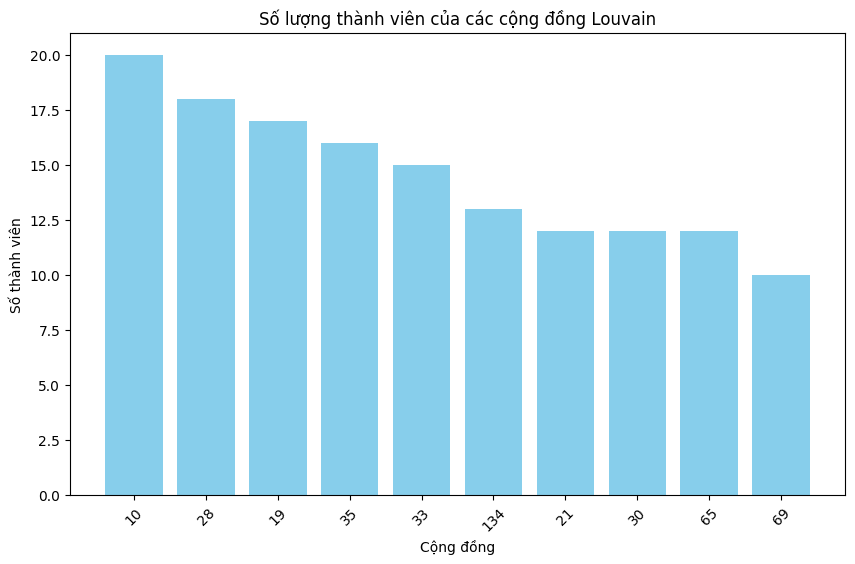

In [7]:
import matplotlib.pyplot as plt

# Dữ liệu
communities = [10, 28, 19, 35, 33, 134, 21, 30, 65, 69]
members = [20, 18, 17, 16, 15, 13, 12, 12, 12, 10]

# Vẽ bar chart
plt.figure(figsize=(10,6))
plt.bar([str(c) for c in communities], members, color='skyblue')
plt.xlabel('Cộng đồng')
plt.ylabel('Số thành viên')
plt.title('Số lượng thành viên của các cộng đồng Louvain')
plt.xticks(rotation=45)
plt.show()


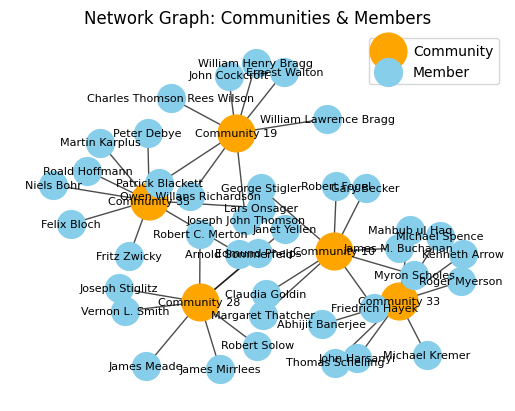

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Dữ liệu cộng đồng ---
communities = {
    10: ["George Stigler", "Myron Scholes", "Margaret Thatcher", "Robert Fogel", 
         "James M. Buchanan", "Friedrich Hayek", "Claudia Goldin", "Gary Becker"],
    28: ["Joseph Stiglitz", "James Mirrlees", "Robert Solow", "Robert C. Merton", 
         "Janet Yellen", "James Meade", "Edmund Phelps", "Vernon L. Smith"],
    19: ["Charles Thomson Rees Wilson", "John Cockcroft", "Patrick Blackett", 
         "Joseph John Thomson", "William Lawrence Bragg", "Ernest Walton", 
         "William Henry Bragg", "Owen Willans Richardson"],
    35: ["Felix Bloch", "Fritz Zwicky", "Lars Onsager", "Roald Hoffmann", 
         "Martin Karplus", "Peter Debye", "Arnold Sommerfeld", "Niels Bohr"],
    33: ["Mahbub ul Haq", "Michael Kremer", "John Harsanyi", "Kenneth Arrow", 
         "Thomas Schelling", "Abhijit Banerjee", "Michael Spence", "Roger Myerson"],
}

# --- 2. Tạo Graph ---
G = nx.Graph()

# Thêm node cộng đồng
for c in communities:
    G.add_node(f"Community {c}", type='community')

# Thêm node thành viên và nối với cộng đồng
for c, members in communities.items():
    for m in members:
        G.add_node(m, type='member')
        G.add_edge(f"Community {c}", m)

# --- 3. Vẽ Graph ---
pos = nx.spring_layout(G, k=0.5, seed=42)  # layout đẹp cho network nhỏ

# Node cộng đồng
community_nodes = [n for n, attr in G.nodes(data=True) if attr['type']=='community']
nx.draw_networkx_nodes(G, pos, nodelist=community_nodes, node_color='orange', node_size=700, label='Community')

# Node thành viên
member_nodes = [n for n, attr in G.nodes(data=True) if attr['type']=='member']
nx.draw_networkx_nodes(G, pos, nodelist=member_nodes, node_color='skyblue', node_size=400, label='Member')

# Các cạnh
nx.draw_networkx_edges(G, pos, width=1, alpha=0.7)

# Nhãn
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network Graph: Communities & Members")
plt.axis('off')
plt.legend(scatterpoints=1)
plt.show()


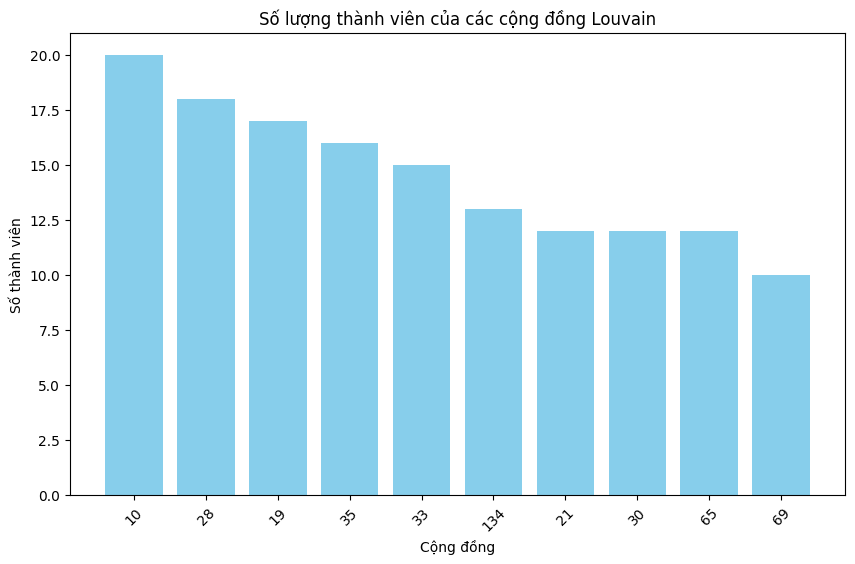

In [9]:
import matplotlib.pyplot as plt

# Dữ liệu
communities = [10, 28, 19, 35, 33, 134, 21, 30, 65, 69]
members = [20, 18, 17, 16, 15, 13, 12, 12, 12, 10]

# Vẽ bar chart
plt.figure(figsize=(10,6))
plt.bar([str(c) for c in communities], members, color='skyblue')
plt.xlabel('Cộng đồng')
plt.ylabel('Số thành viên')
plt.title('Số lượng thành viên của các cộng đồng Louvain')
plt.xticks(rotation=45)

# Lưu ảnh
plt.savefig('community_bar_chart.png', dpi=300, bbox_inches='tight')

plt.show()
